In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from scipy.spatial.distance import pdist, cdist
from scipy.spatial import cKDTree
import seaborn as sns
import pandas as pd

from tqdm import tqdm
import os

from src.models import ContextSpaceNet, OldSpaceNet, RecurrentSpaceNet, Decoder, End2EndSpaceNet
from src.utils import ratemap_collage, SimpleDatasetMaker

plt.rcdefaults()
plt.style.use("figures/project_style.mplstyle")
%matplotlib inline

In [5]:
figure_path = '/Users/frederikrogge/Documents/Projekte/PhD/Projects/BSR/figures-new'
path = "/Users/frederikrogge/Data/bsr/feed-forward-new"

Helper functions

In [6]:
# Helper function

def get_spatial_representation(model, n_grid, val_range=(-1, 1)):
    """
    Get spatial representation of model on a grid.

    Parameters
    ----------
    model : torch.nn.Module
        Model to evaluate.
    n_grid : int
        Number of points on grid.
    val_range : tuple, optional
        Range of values to evaluate model on, by default (-1, 1).

    Returns
    -------
    np.ndarray
        Spatial representation of model on grid.

    """
    x = np.linspace(val_range[0], val_range[1], n_grid)
    y = x.copy()
    xx, yy = np.meshgrid(x,y)
    u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)
    p = model.spatial_representation(u).detach().numpy()

    return p

def train_model(model, train_steps, bs, lr):
    """
    Train a model.

    Parameters
    ----------
    model : torch.nn.Module
        Model to train.
    train_steps : int
        Number of training steps.
    bs : int
        Batch size.
    lr : float
        Learning rate.

    Returns
    -------
    torch.nn.Module
        Trained model.

    """
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train model
    loss_history = []
    progress = tqdm(range(train_steps))
    for i in progress:

        # Sample random batch
        r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype=torch.float32)

        # Perform train step
        loss = model.train_step(x=r, y=r, optimizer=optimizer)

        # Save loss
        loss_history.append(loss)

        # Update progress bar
        if i % 10 == 0:
            progress.set_description(f"loss: {loss:>7f}")

    return model, loss_history

def compute_mean_error(model, n_grid, ns, weight_by_activity=True):
    """
    Compute mean error for different number of units used for decoding.

    Parameters
    ----------
    model : torch.nn.Module
        Model to evaluate.
    n_grid : int
        Number of points on grid.
    ns : list
        List of number of units to use for decoding.
    weight_by_activity : bool, optional
        Whether to weight the decoded position by the activity of the units, by default True.

    Returns
    -------
    list
        List of mean errors for different number of units used for decoding.

    """

    # Evaluate on nxn grid
    x = np.linspace(-1, 1, n_grid)
    y = x.copy()
    xx, yy = np.meshgrid(x,y)
    u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)
    p_grid = model.spatial_representation(u).detach().numpy()

    # Find peak location for each unit
    peak_idx = np.argmax(p_grid, axis=0)
    peak_loc = u.detach().numpy()[peak_idx]

    errors = []

    for n in ns:

        # Get top n active units for each position
        top_n = np.argsort(p_grid, axis=1)[:, -n:]  # (n_grid**2, n)

        # Get their peak locations
        top_n_peak_loc = peak_loc[top_n]            # (n_grid**2, n, 2)

        # Compute their activity at each position
        if weight_by_activity:
            weights = p_grid[np.arange(n_grid**2)[:, None], top_n]  # (n_grid**2, n)
        else:
            weights = np.ones_like(top_n, dtype=float)

        # Use einsum to compute weighted average of top n units
        # This performs an elementwise multiplication of the weights at each position with the peak locations and then sums over the units
        decoded_pos = np.einsum("ijk,ij->ik", top_n_peak_loc, weights) / np.sum(weights, axis=1)[:, None]

        # Compute error (euclidean distance between decoded and actual position)
        error = np.sqrt(np.sum((decoded_pos - u.detach().numpy())**2, axis=-1))

        # Compute mean error
        mean_error = np.mean(error)

        # Append to list
        errors.append(mean_error)

    return errors

# Normal space net

Train models

Training 100 units
Training 500 units
Model 3


loss: 0.000089: 100%|██████████| 50000/50000 [02:12<00:00, 376.78it/s]


Model 4


loss: 0.000085: 100%|██████████| 50000/50000 [01:54<00:00, 434.79it/s]


Model 5


loss: 0.000087: 100%|██████████| 50000/50000 [02:13<00:00, 374.56it/s]


Model 6


loss: 0.000091: 100%|██████████| 50000/50000 [01:29<00:00, 556.56it/s]


Model 7


loss: 0.000087: 100%|██████████| 50000/50000 [01:46<00:00, 470.96it/s]


Model 8


loss: 0.000087: 100%|██████████| 50000/50000 [02:02<00:00, 408.33it/s]


Model 9


loss: 0.000079: 100%|██████████| 50000/50000 [01:27<00:00, 570.24it/s]


Model 10


loss: 0.000084: 100%|██████████| 50000/50000 [00:55<00:00, 906.66it/s]


Training 1000 units
Model 1


loss: 0.000047: 100%|██████████| 50000/50000 [01:46<00:00, 467.67it/s]


Model 2


loss: 0.000056: 100%|██████████| 50000/50000 [01:42<00:00, 486.02it/s]


Model 3


loss: 0.000064: 100%|██████████| 50000/50000 [01:45<00:00, 474.50it/s]


Model 4


loss: 0.000050: 100%|██████████| 50000/50000 [01:32<00:00, 542.70it/s]


Model 5


loss: 0.000049: 100%|██████████| 50000/50000 [01:31<00:00, 545.14it/s]


Model 6


loss: 0.000049: 100%|██████████| 50000/50000 [01:21<00:00, 614.96it/s]


Model 7


loss: 0.000046: 100%|██████████| 50000/50000 [01:29<00:00, 561.04it/s]


Model 8


loss: 0.000047: 100%|██████████| 50000/50000 [01:20<00:00, 617.67it/s]


Model 9


loss: 0.000051: 100%|██████████| 50000/50000 [01:18<00:00, 636.31it/s]


Model 10


loss: 0.000053: 100%|██████████| 50000/50000 [01:19<00:00, 630.74it/s]


Training 100 units 01 scale
Model 1


loss: 0.000902: 100%|██████████| 50000/50000 [00:33<00:00, 1474.88it/s]


Model 2


loss: 0.000870: 100%|██████████| 50000/50000 [00:33<00:00, 1476.89it/s]


Model 3


loss: 0.000911: 100%|██████████| 50000/50000 [00:33<00:00, 1499.54it/s]


Model 4


loss: 0.001012: 100%|██████████| 50000/50000 [00:32<00:00, 1544.86it/s]


Model 5


loss: 0.001073: 100%|██████████| 50000/50000 [00:32<00:00, 1529.38it/s]


Model 6


loss: 0.000926: 100%|██████████| 50000/50000 [01:12<00:00, 690.64it/s] 


Model 7


loss: 0.001077: 100%|██████████| 50000/50000 [01:00<00:00, 828.86it/s] 


Model 8


loss: 0.000955: 100%|██████████| 50000/50000 [00:58<00:00, 852.03it/s] 


Model 9


loss: 0.000854: 100%|██████████| 50000/50000 [01:20<00:00, 619.50it/s] 


Model 10


loss: 0.001000: 100%|██████████| 50000/50000 [01:14<00:00, 669.28it/s] 


Training 100 units 05 scale
Model 1


loss: 0.000345: 100%|██████████| 50000/50000 [00:55<00:00, 902.13it/s] 


Model 2


loss: 0.000342: 100%|██████████| 50000/50000 [00:48<00:00, 1025.78it/s]


Model 3


loss: 0.000344: 100%|██████████| 50000/50000 [00:53<00:00, 929.72it/s] 


Model 4


loss: 0.000342: 100%|██████████| 50000/50000 [00:49<00:00, 1002.52it/s]


Model 5


loss: 0.000344: 100%|██████████| 50000/50000 [01:25<00:00, 588.08it/s]


Model 6


loss: 0.000344: 100%|██████████| 50000/50000 [01:08<00:00, 726.59it/s] 


Model 7


loss: 0.000346: 100%|██████████| 50000/50000 [01:22<00:00, 603.05it/s] 


Model 8


loss: 0.000344: 100%|██████████| 50000/50000 [01:24<00:00, 590.64it/s] 


Model 9


loss: 0.000346: 100%|██████████| 50000/50000 [00:57<00:00, 871.31it/s] 


Model 10


loss: 0.000346: 100%|██████████| 50000/50000 [01:14<00:00, 667.70it/s] 


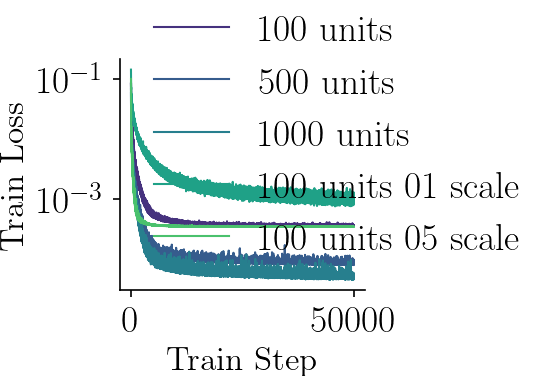

In [8]:
# ----------------------- Params -----------------------
train_steps = 50000      # no. of training steps
bs = 64                # batch size
n_in = 2                # 2 position inputs
scale = 0.25            # scale of the gaussian
lam = 0.1                 # regularization strength
lr = 1e-4               # learning rate
beta = 0.5              # rescaling parameter

# Analyze for different model parameters
models = {
    "100 units": [OldSpaceNet(n_in, 100, scale=scale, lam=lam) for _ in range(10)],
    "500 units": [OldSpaceNet(n_in, 500, scale=scale, lam=lam) for _ in range(10)],
    "1000 units": [OldSpaceNet(n_in, 1000, scale=scale, lam=lam) for _ in range(10)],
    "100 units 01 scale": [OldSpaceNet(n_in, 100, scale=0.1, lam=lam) for _ in range(10)],
    # "1000 units 01 scale": [OldSpaceNet(n_in, 1000, scale=0.1, lam=lam) for _ in range(10)],
    "100 units 05 scale": [OldSpaceNet(n_in, 100, scale=0.5, lam=lam) for _ in range(10)],
}

loss_histories = {name: [] for name in models.keys()}

# --------------------- Training ----------------------

for name, model in models.items():
    print(f"Training {name}")
    for i, m in enumerate(model):
        
        if os.path.exists(f"{path}/{name}_{i}.pt"):
            model = torch.load(f"{path}/{name}_{i}.pt")
            loss_history = np.load(f"{path}/{name}_{i}_loss_history.npy")
            loss_histories[name].append(loss_history)
            continue
            
        print(f"Model {i+1}")
        models[name][i], loss_history = train_model(m, train_steps, bs, lr)
        loss_histories[name].append(loss_history)

        # Save model and loss history
        torch.save(m, f"{path}/{name}_{i}.pt")
        np.save(f"{path}/{name}_{i}_loss_history.npy", loss_history)

    # models[name], loss_history = train_model(model, train_steps, bs, lr)
    plt.semilogy(np.arange(len(loss_history)), loss_history, label=name)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")
plt.legend()
plt.show()


Load results

In [9]:
# Load models
models = {
    "100 units": [torch.load(f"{path}/100 units_{i}.pt") for i in range(10)],
    "500 units": [torch.load(f"{path}/500 units_{i}.pt") for i in range(10)],
    "1000 units": [torch.load(f"{path}/1000 units_{i}.pt") for i in range(10)],
    "100 units 01 scale": [torch.load(f"{path}/100 units 01 scale_{i}.pt") for i in range(10)],
    "100 units 05 scale": [torch.load(f"{path}/100 units 05 scale_{i}.pt") for i in range(10)],
    # "1000 units 01 scale": [torch.load(f"{path}/1000 units 01 scale_{i}.pt") for i in range(10)],
}

# Load loss histories
loss_histories = {name: [np.load(f"{path}/{name}_{i}_loss_history.npy") for i in range(10)] for name in models.keys()}

model_name_map = {
    "100 units": "n=100, $\sigma$=0.25",
    "500 units": "n=500, $\sigma$=0.25",
    "1000 units": "n=1000, $\sigma$=0.25",
    "100 units 01 scale": r"n=100, $\sigma$=0.1",
    "100 units 05 scale": r"n=100, $\sigma$=0.5",
    "1000 units 01 scale": r"n=1000, $\sigma$=0.1",
}

## Loss history

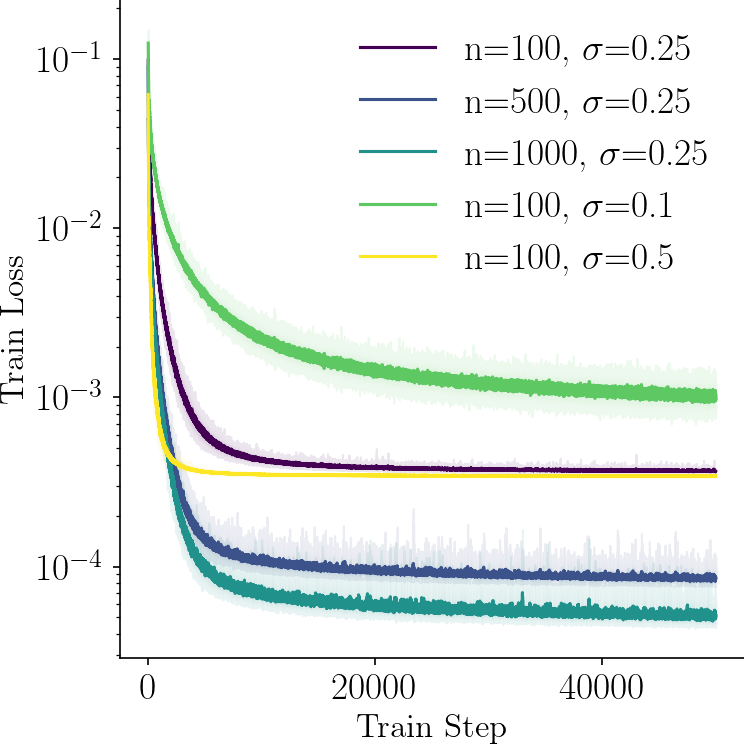

In [11]:
# Load viridis colormap
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 1, len(models))]

# Plot performance
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
for i, (name, loss_history) in enumerate(loss_histories.items()):
    ax.semilogy(np.arange(len(loss_history[0])), np.mean(loss_history, axis=0), label=model_name_map[name], color=colors[i], lw=1.5)
    ax.fill_between(np.arange(len(loss_history[0])), np.min(loss_history, axis=0), np.max(loss_history, axis=0), alpha=0.1, color=colors[i])
ax.set_xlabel("Train Step")
ax.set_ylabel("Train Loss")
ax.legend()

fig.savefig(os.path.join(figure_path, 'dense_training_loss.svg'), transparent=True)
plt.show()

## Representations

In [28]:
model_name = "100 units"
model = models[model_name][0]

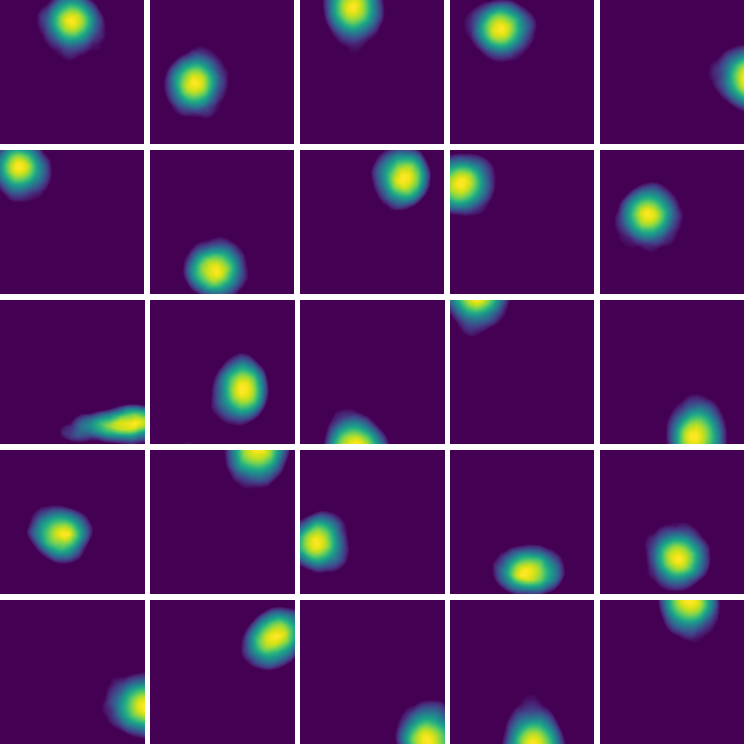

In [30]:
n = 1024

# Get spatial representations of grid
p = get_spatial_representation(model, n)

# Find cells with nonzero values
mask = np.mean(p, axis=0) > 0
ratemaps = p.T[mask].reshape(-1, n, n)

# Plot first 25 ratemaps (active units)
fig, ax = ratemap_collage(ratemaps[:25], cmap="viridis")      # jet, viridis
plt.show()

fig.savefig(os.path.join(figure_path, f'dense_ratemaps_{model_name}.svg'), transparent=True)

## Active units

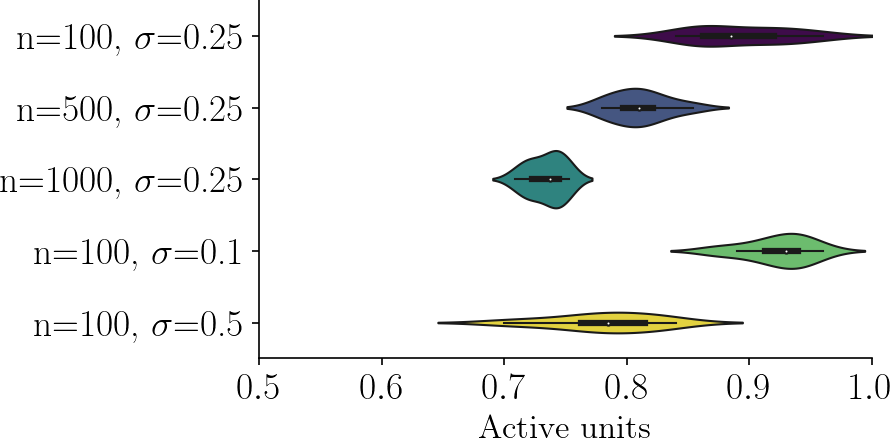

In [32]:
# Get spatial representations of grid
n_grid = 128
x = np.linspace(-1, 1, n_grid)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)

df = []
for name, model in models.items():
    for m in model:
        p_grid = m.spatial_representation(u).detach().numpy()
        mask = np.mean(p_grid, axis=0) > 0

        df.append(pd.DataFrame({
            "active_units": [np.sum(mask) / len(mask)],
            "model": [model_name_map[name]]
        }))

df = pd.concat(df, ignore_index=True)

g = sns.catplot(
    data=df,
    y="model",
    x="active_units",
    # kind="strip",
    kind="violin",
    palette=colors,
    alpha=0.5,
    height=3,
    aspect=2,
)

g.set_axis_labels("Active units", "")
g.set(xlim=(0.5, 1))

g.fig.savefig(os.path.join(figure_path, 'dense_fraction_active_units.svg'), transparent=True)
plt.show()


## Mean rate and peaks

In [36]:
only_active = True

# Get spatial representations of grid
n_grid = 1024
x = np.linspace(-1, 1, n_grid)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)

df = []
for name, model in models.items():
    for i, m in enumerate(model):
        p_grid = m.spatial_representation(u).detach().numpy()

        if only_active:
            
            # Only take the mean where each unit is active
            p_grid[p_grid <= 0] = np.nan

        df.append(pd.DataFrame({
            "mean_rate": np.nanmean(p_grid, axis=0),
            "peak": np.nanmax(p_grid, axis=0),
            "model": model_name_map[name],
            "iteration": i
        }))

df = pd.concat(df, ignore_index=True)

/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_69466/2818121734.py:21: RuntimeWarning: Mean of empty slice
  "mean_rate": np.nanmean(p_grid, axis=0),
/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_69466/2818121734.py:22: RuntimeWarning: All-NaN slice encountered
  "peak": np.nanmax(p_grid, axis=0),


Mean rate

/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_69466/3103077976.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.catplot(


<Figure size 1500x450 with 0 Axes>

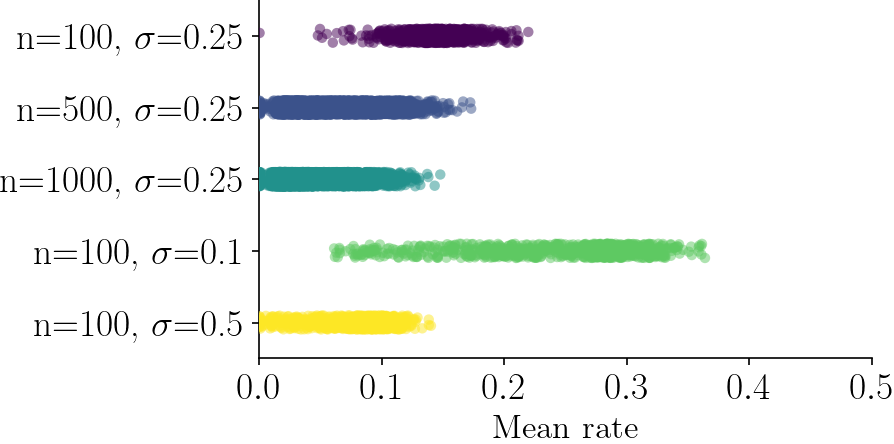

In [40]:
plt.figure(figsize=(10, 3))

# Make plot horizontal
g = sns.catplot(
    data=df,
    y="model",
    x="mean_rate",
    kind="strip",
    palette=colors,
    alpha=0.5,
    height=3,
    aspect=2,
    # dodge=True,
)

g.set_axis_labels("Mean rate", "")
# g.set_axis_labels("Peak", "")
g.set(xlim=(0, 0.5))

g.fig.savefig(os.path.join(figure_path, 'dense_mean_rate.svg'), transparent=True)
plt.show()


Peak

/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_69466/299220812.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.catplot(


<Figure size 1500x450 with 0 Axes>

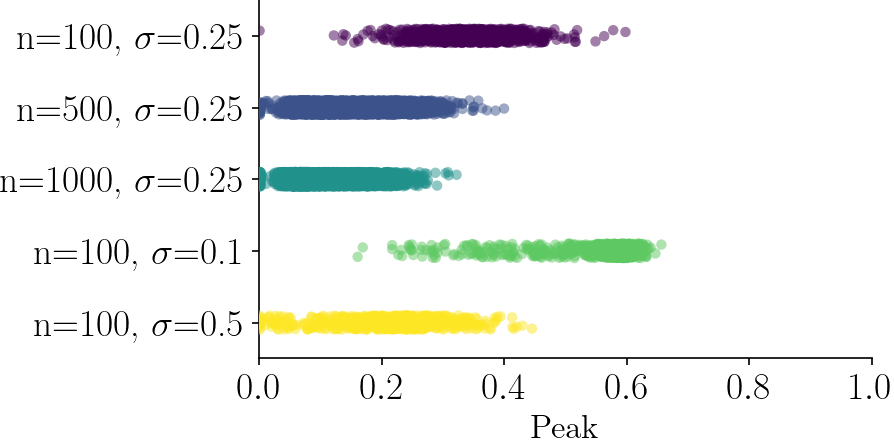

In [41]:
plt.figure(figsize=(10, 3))

# Make plot horizontal
g = sns.catplot(
    data=df,
    y="model",
    x="peak",
    kind="strip",
    palette=colors,
    alpha=0.5,
    height=3,
    aspect=2,
    # dodge=True,
)

# g.set_axis_labels("Mean rate", "")
g.set_axis_labels("Peak", "")
g.set(xlim=(0, 1))

g.fig.savefig(os.path.join(figure_path, 'dense_peak_rate.svg'), transparent=True)
plt.show()


## Similarity structure

Analyze learned similarity structure

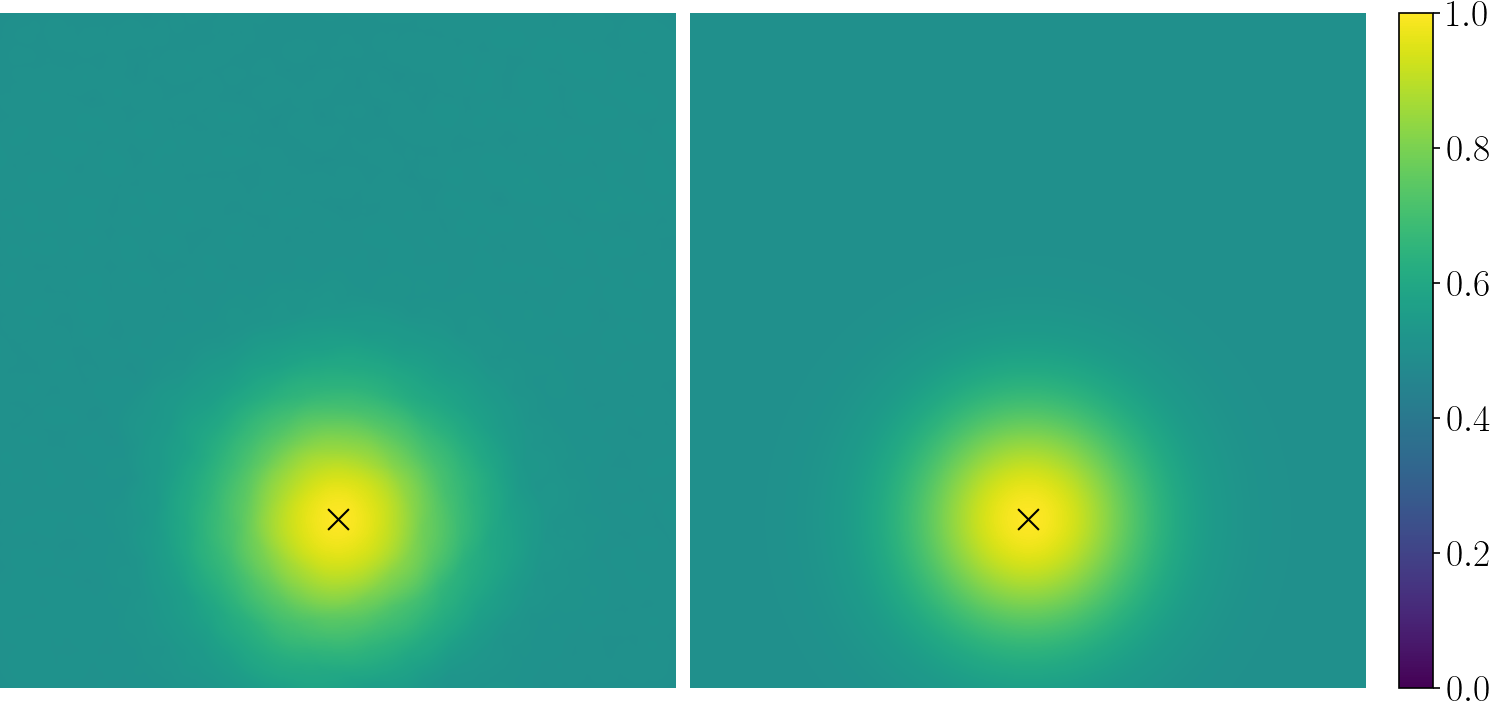

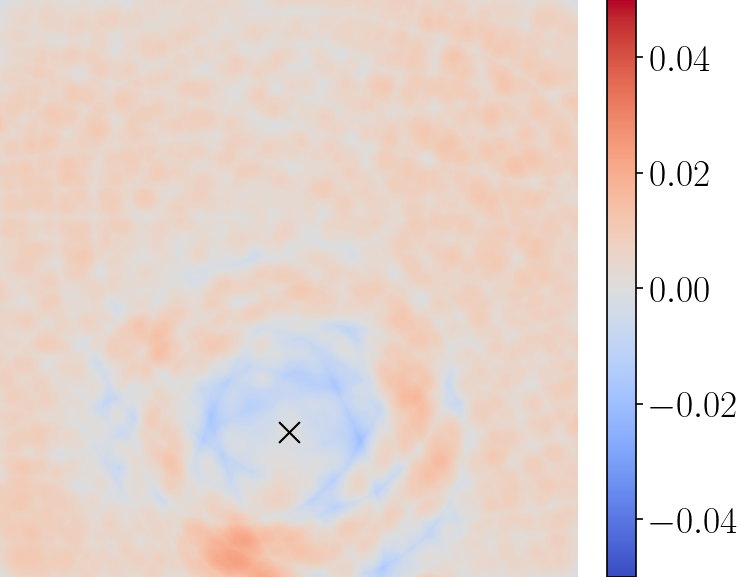

In [58]:
model = models["100 units"][0]

pos_name = "bottom"
scale = 0.25
beta = 0.5

positions = {
    # 'center': [64, 64],
    # 'corner': [0, 0],
    # 'bottom': [32, 64]
    'center': [512, 512],
    'corner': [0, 0],
    'bottom': [256, 512]
}

pos = positions[pos_name]

# Evaluate on nxn grid
n = 1024
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype= torch.float32)
p = model.spatial_representation(u).detach().numpy()

# Define grid
grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)

# Compute position in flat array
pos_flat = np.ravel_multi_index(pos, (n, n))

# Compute similarity of the 'p' based on this, but with numpy
dp = cdist(p, p[pos_flat][None]) **2
corr = np.exp(-dp)

# Same for actual grid
grid_dist = cdist(grid, grid[pos_flat][None]) **2
grid_corr = np.exp((-0.5 / scale ** 2) * grid_dist)
grid_corr = (1 - beta) * grid_corr + beta

# Create figure
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Spatial representations
im = axs[0].imshow(corr.reshape(n, n), origin="lower", cmap="viridis", vmin=0, vmax=1)
axs[0].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[0].axis("off")

# Grid
im = axs[1].imshow(grid_corr.reshape(n, n), origin="lower", cmap="viridis", vmin=0, vmax=1)
axs[1].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[1].axis("off")

# Add a colorbar to the figure
fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=.05)

plt.show()

fig.savefig(os.path.join(figure_path, f'dense_similarity_structure_{pos_name}_{model_name}.svg'), transparent=True)

# Difference
fig, axs = plt.subplots(figsize=(5, 5))
# im = axs.imshow(np.abs(corr - grid_corr).reshape(n, n), origin="lower", cmap="viridis", vmin=0, vmax=0.1)
im = axs.imshow((corr - grid_corr).reshape(n, n), origin="lower", cmap="coolwarm", vmin=-0.05, vmax=0.05)
axs.scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs.axis("off")

# Add a colorbar to the figure
fig.colorbar(im, ax=axs, orientation='vertical', fraction=.05)

plt.show()

fig.savefig(os.path.join(figure_path, f'dense_similarity_structure_error_{pos_name}_{model_name}.svg'), transparent=True)

## Position decoding

### Compute and plot peak positions of units

In [68]:
model_name = "100 units 05 scale"
model = models[model_name][0]

In [69]:
# Get spatial representations of grid
n_grid = 1024

# Get spatial representations
p_grid = get_spatial_representation(model, n_grid)

# Find peak location for each unit
peak_idx = np.argmax(p_grid, axis=0)
peak_loc = u.detach().numpy()[peak_idx]

# Find units with nonzero values
mask = np.mean(p_grid, axis=0) > 0

print(f"Resolution: {2/n_grid:.3f}")
print(f"Percentage of units with nonzero values: {np.mean(mask) * 100:.2f}%")

Resolution: 0.002
Percentage of units with nonzero values: 70.00%


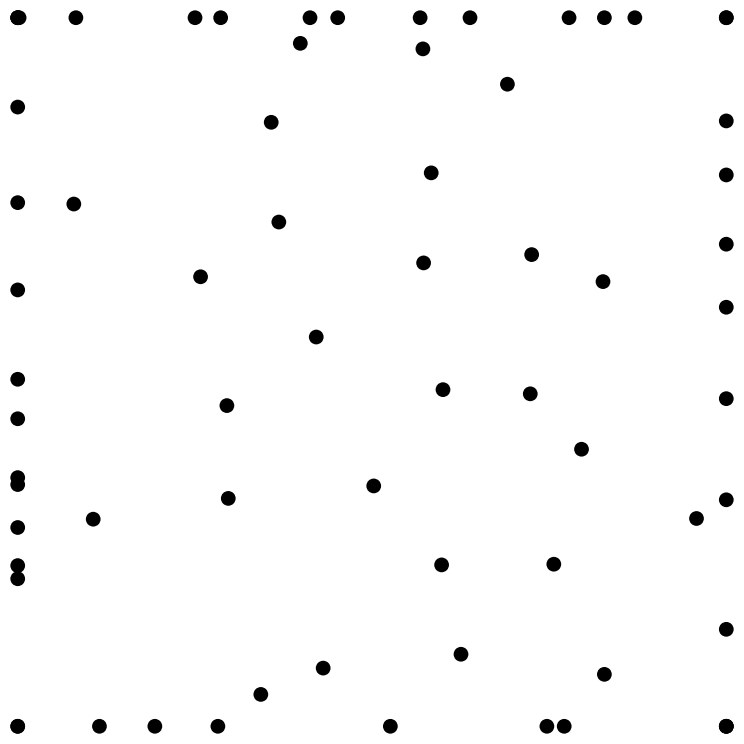

In [70]:
# Plot peak positions
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(peak_loc[mask, 0], peak_loc[mask, 1], marker="o", color="black", s=50, alpha=1, edgecolors='none')
ax.axis("off")

ax.set_ylim(-1.05, 1.05)
ax.set_xlim(-1.05, 1.05)
fig.savefig(os.path.join(figure_path, f'dense_peak_positions_{model_name}.svg'), transparent=True)
plt.show()


KDE plot

<AxesSubplot: >

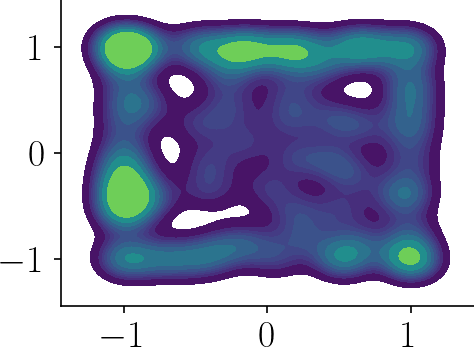

In [71]:
sns.kdeplot(x=peak_loc[mask, 0], y=peak_loc[mask, 1], cmap="viridis", bw_method=0.2, fill=True)

### Compute nearest neighbor distances

In [ ]:


positions = peak_loc[mask]
random_positions = np.random.uniform(-1, 1, (positions.shape[0], 2))

# Build a KD-Tree
tree = cKDTree(positions)
rand_tree = cKDTree(random_positions)

# Query the nearest neighbor for each point (k=2 because the first nearest neighbor is the point itself)
distances, _ = tree.query(positions, k=2)
rand_distances, _ = rand_tree.query(random_positions, k=2)

# The nearest neighbor distances (excluding the distance to the point itself which is 0)
nn_distances = distances[:, 1]
rand_nn_distances = rand_distances[:, 1]

# Compute mean and std
std_dev = np.std(nn_distances)
mean = np.mean(nn_distances)
rand_std_dev = np.std(rand_nn_distances)
rand_mean = np.mean(rand_nn_distances)

print(f"Mean nearest neighbor distance: {mean:.3f} ({rand_mean:.3f})")
print(f"Std nearest neighbor distance: {std_dev:.3f} ({rand_std_dev:.3f})")

# Plot histogram
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(nn_distances, bins=100, label="Actual")
ax.hist(rand_nn_distances, bins=100, label="Random")
ax.set_xlabel("Nearest neighbor distance")
ax.set_ylabel("Count")
ax.set_title("Nearest neighbor distance histogram")
ax.legend(frameon=False)
plt.show()

### Decoding from top $n$ units

In [72]:
model_name = "100 units"
model = models[model_name][0]

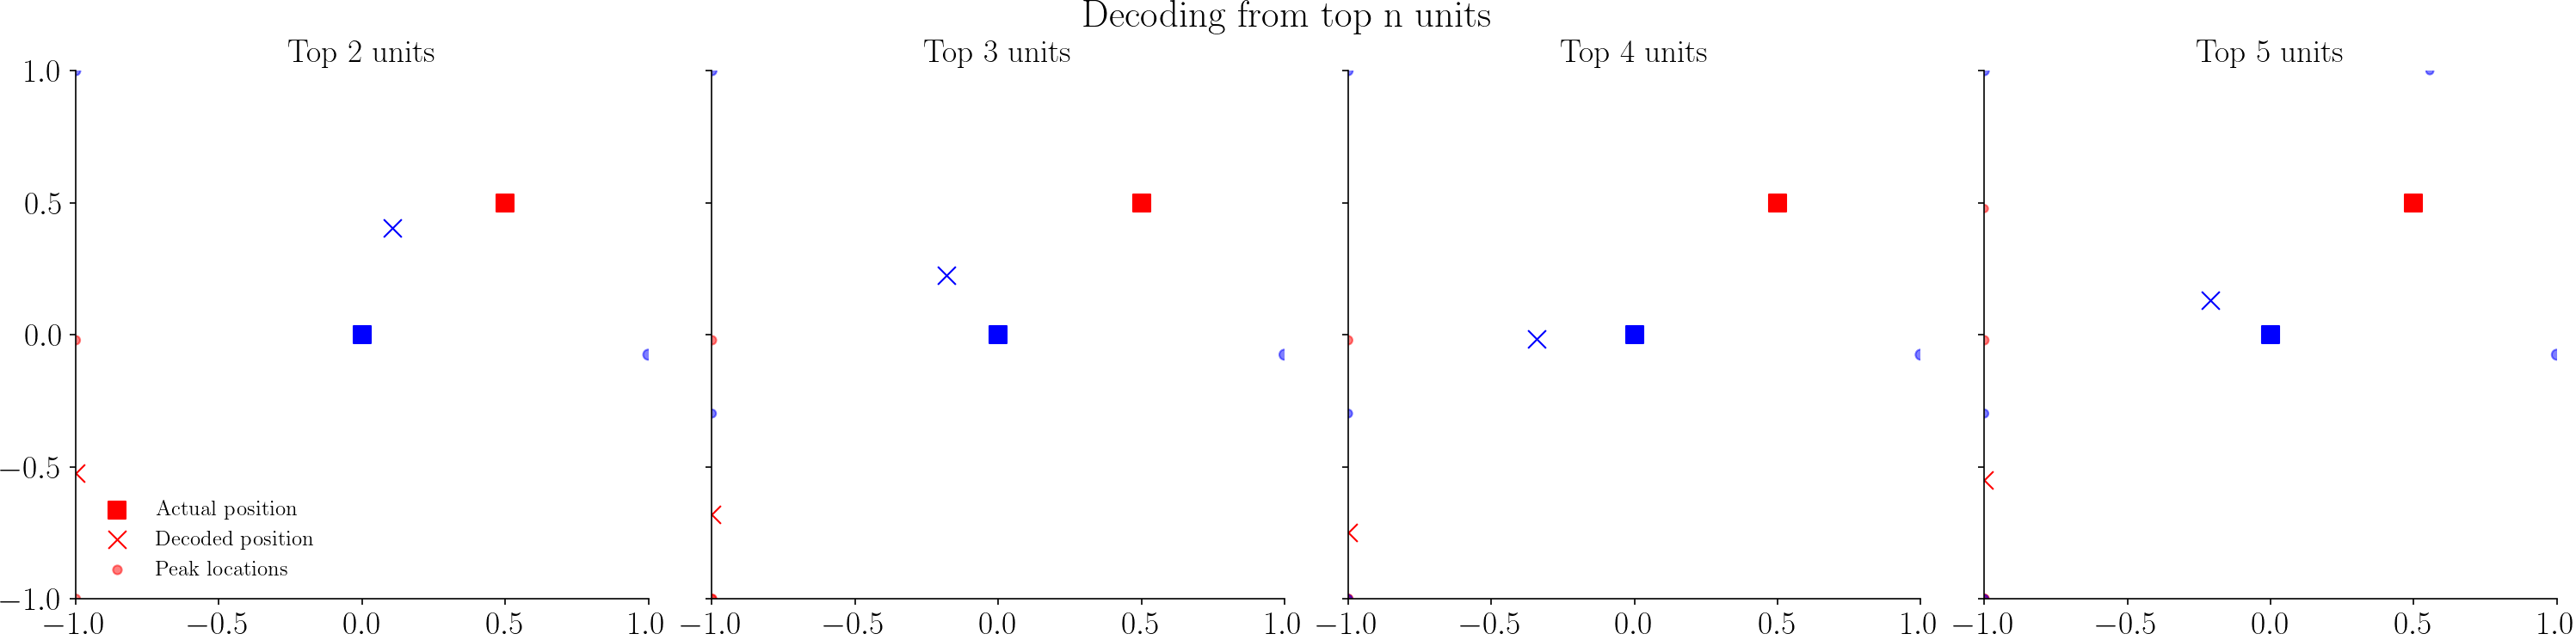

In [73]:
# ----------------------- Params -----------------------

ns = [2, 3, 4, 5]               # no. of top units to use for decoding
positions = [
    [0.5, 0.5],
    [0., 0.]
]

# Define colors (at least as many as positions)
colors = ["red", "blue", "green"]

# --------------------- Decoding ----------------------

# Get spatial representations
p = model.spatial_representation(torch.tensor(positions, dtype=torch.float32)).detach().numpy()

# Create figure
fig, axs = plt.subplots(figsize=(len(ns) * 5, 5), ncols=len(ns), sharex=True, sharey=True)

for k, n in enumerate(ns):

    ax = axs[k]

    # For each row, get the top n units
    top_n = np.argsort(p, axis=1)[:, -n:]

    for i, pos in enumerate(positions):

        # Plot the position
        ax.scatter(pos[0], pos[1], marker="s", color=colors[i], s=100)

        # Compute weighted average of top n units using their peak locations
        top_n_peak_loc = peak_loc[top_n[i]]
        weights = p[i, top_n[i]]

        # Compute dot product to get decoded position
        decoded_pos = np.dot(weights, top_n_peak_loc) / np.sum(weights)

        # Plot decoded position
        ax.scatter(decoded_pos[0], decoded_pos[1], marker="x", color=colors[i], s=100)

        # Plot top n unit's peak locations, the size of the dot is proportional to the weight
        ax.scatter(top_n_peak_loc[:, 0], top_n_peak_loc[:, 1], s=weights*100, color=colors[i], marker="o", alpha=0.5)

    # Set axis limits
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)

    # Set ticks and labels
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])

    # Add legend
    if k == 0:
        ax.legend(["Actual position", "Decoded position", "Peak locations"], loc='lower left', prop={'size': 12})

    ax.set_title(f"Top {n} units")

fig.suptitle("Decoding from top n units")
# fig.savefig('dense_decoding.png', transparent=True)
plt.show()

Now, let's take a more systematic approach, and decode from top $n$ units for all positions

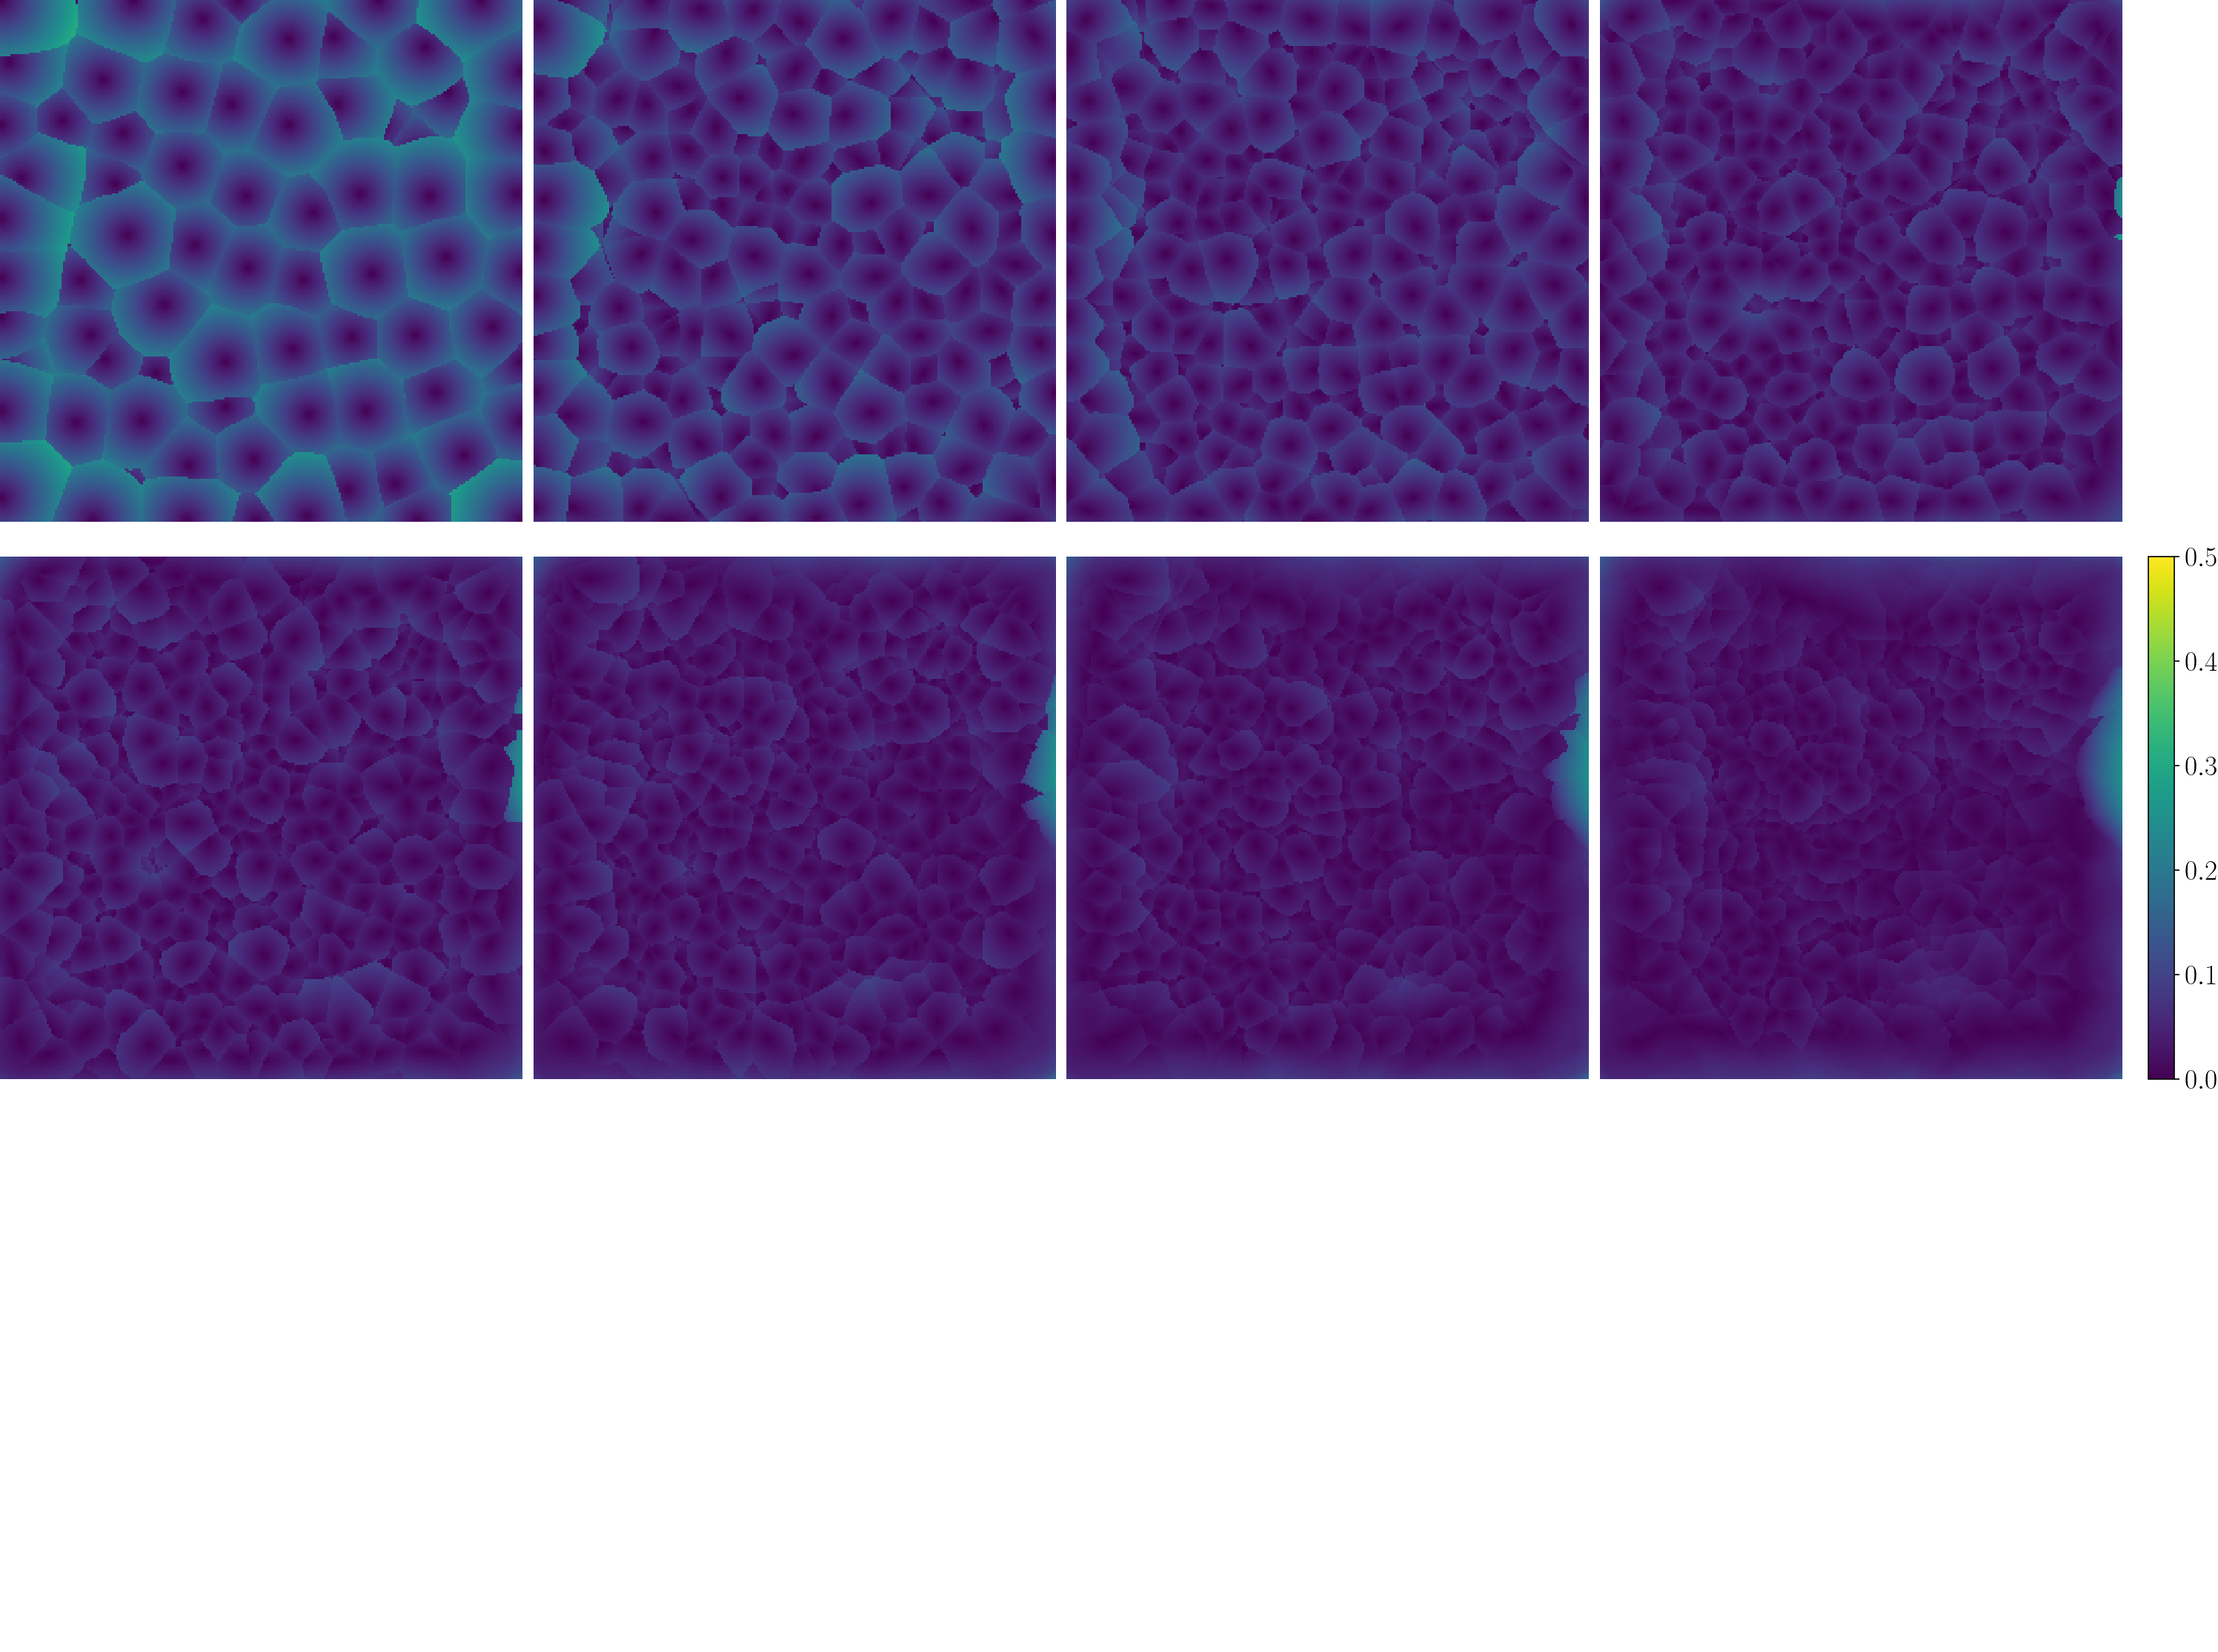

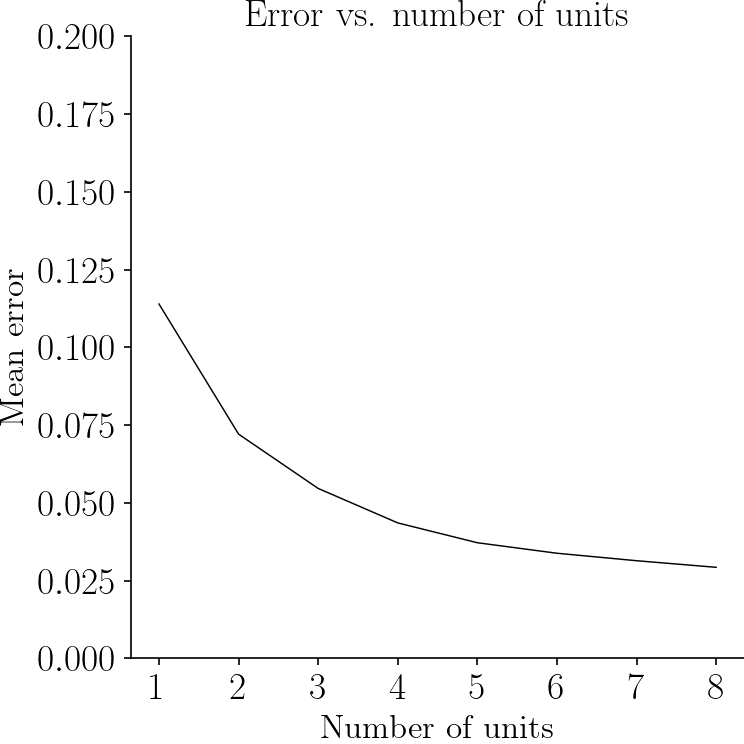

In [74]:
# model_name = "100 units (0.1 scale)"
model_name = "100 units"

model = models[model_name][0]

# ----------------------- Params -----------------------

ns = np.arange(1, 9)        # no. of top units to use for decoding
n_grid = 256                 # no. of points on grid
weight_by_activity = True    # weight decoded position by activity of units

# --------------------- Decoding ----------------------

x = np.linspace(-1, 1, n_grid)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)
p_grid = model.spatial_representation(u).detach().numpy()

# Find peak location for each unit
peak_idx = np.argmax(p_grid, axis=0)
peak_loc = u.detach().numpy()[peak_idx]

errors = []

# Col wrap after
cols = 4
rows = len(ns) // cols + 1

fig, axs = plt.subplots(figsize=(cols * 5, rows * 5), ncols=cols, nrows=rows, sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()
for k, n in enumerate(ns):

    # Get axis
    ax = axs[k]

    # Get top n active units for each position
    top_n = np.argsort(p_grid, axis=1)[:, -n:]  # (n_grid**2, n)

    # Get their peak locations
    top_n_peak_loc = peak_loc[top_n]            # (n_grid**2, n, 2)

    # Compute their activity at each position
    if weight_by_activity:
        weights = p_grid[np.arange(n_grid**2)[:, None], top_n]  # (n_grid**2, n)
    else:
        weights = np.ones_like(top_n, dtype=float)

    # Use einsum to compute weighted average of top n units
    # This performs an elementwise multiplication of the weights at each position with the peak locations and then sums over the units
    decoded_pos = np.einsum("ijk,ij->ik", top_n_peak_loc, weights) / np.sum(weights, axis=1)[:, None]

    # Compute error (euclidean distance between decoded and actual position)
    error = np.sqrt(np.sum((decoded_pos - u.detach().numpy())**2, axis=-1))

    # Plot error map
    im = ax.imshow(error.reshape(n_grid, n_grid), origin="lower", vmin=0, vmax=0.5)
    ax.axis("off")
    # ax.set_title(f"Top {n} unit{'s' if n > 1 else ''}")
    ax.set_title(f"")

    # Add colorbar
    if k == len(ns) - 1:
        fig.colorbar(im, ax=ax, orientation='vertical', fraction=.05)

    # Compute mean error
    mean_error = np.mean(error)

    # Append to list
    errors.append(mean_error)

for k in range(len(ns), len(axs)):
    axs[k].axis("off")

# fig.suptitle("Error maps")

fig.savefig(os.path.join(figure_path, f'dense_error_maps_{model_name}.svg'), transparent=True)

plt.show()

# Plot error vs. n
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(ns, errors, "-k", linewidth=0.7)
ax.set_ylim(0, 0.2)
if len(ns) > 10:
    ax.set_xticks(ns[::2])
else:
    ax.set_xticks(ns)
ax.set_xlabel("Number of units")
ax.set_ylabel("Mean error")
ax.set_title("Error vs. number of units")

plt.show()


Decoding error

In [75]:
# Evaluate mean error for different number of units
n_grid = 256
ns = np.arange(1, 51)
errors = {name: [] for name in models.keys()}
for name, model in models.items():
    for m in model:
        errors[name].append(compute_mean_error(m, n_grid, ns, weight_by_activity=True))


In [78]:
# Load viridis colormap
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 1, len(models))]

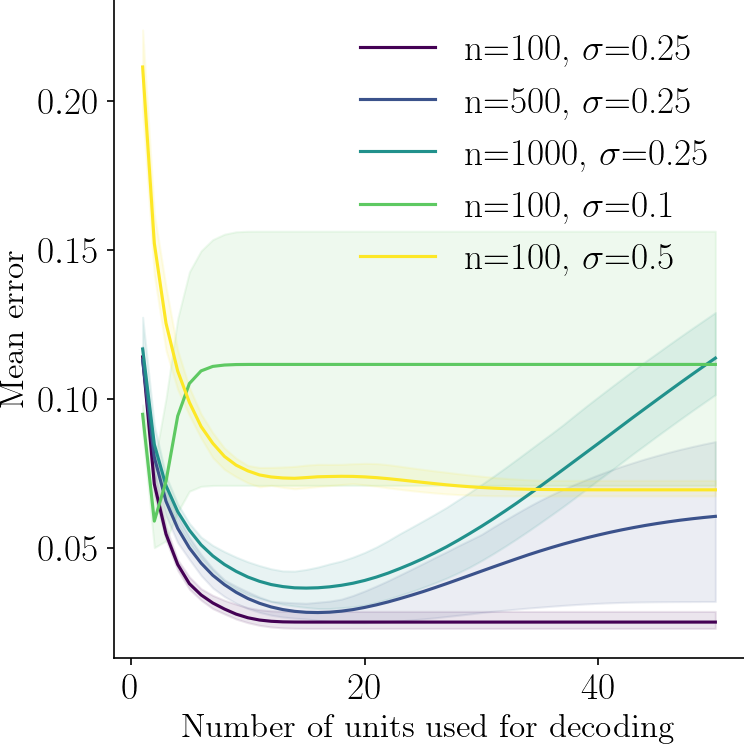

In [79]:
# Plot error vs. n
fig, ax = plt.subplots(figsize=(5, 5))
for i, (name, error) in enumerate(errors.items()):
    ax.plot(ns, np.mean(error, axis=0), label=model_name_map[name], color=colors[i], lw=1.5)
    ax.fill_between(ns, np.min(error, axis=0), np.max(error, axis=0), alpha=0.1, color=colors[i])
ax.set_xlabel("Number of units used for decoding")
ax.set_ylabel("Mean error")
ax.legend()
plt.show()

fig.savefig(os.path.join(figure_path, 'dense_error_vs_n.svg'), transparent=True)

### Compare weighted vs unweighted decoding

In [80]:
weighted_vs_unweighted = {
    "Weighted": compute_mean_error(models["100 units"][0], n_grid, ns, weight_by_activity=True),
    "Unweighted": compute_mean_error(models["100 units"][0], n_grid, ns, weight_by_activity=False)
}


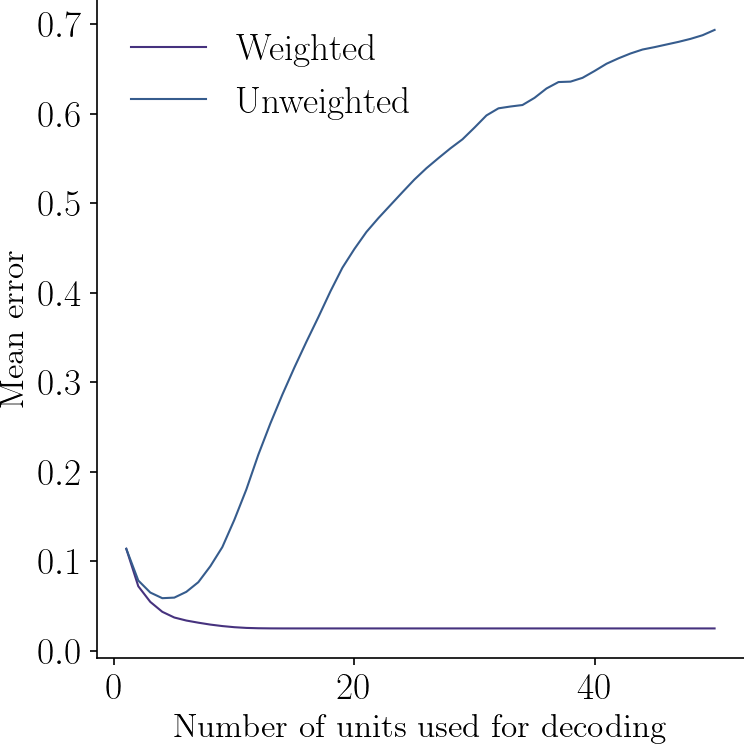

In [81]:
# Plot error vs. n
fig, ax = plt.subplots(figsize=(5, 5))
for name, error in weighted_vs_unweighted.items():
    ax.plot(ns, error, label=name)
ax.set_xlabel("Number of units used for decoding")
ax.set_ylabel("Mean error")
ax.legend()
plt.show()

### Train decoder to decode position from spatial representation

In [ ]:
def train_decoder(model, train_steps, bs, lr, n_out):
    # Define decoder and optimizer
    decoder = Decoder(n_in=n_out, n_out=2)
    optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

    # Train decoder
    decoder_history = []
    progress = tqdm(range(train_steps))
    for i in progress:

        # Sample random batch
        r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype=torch.float32)

        # Get spatial representation
        p = model.spatial_representation(r).detach()

        # Reshape to (bs, n_out)
        p = torch.reshape(p, (-1, p.shape[-1]))

        # Train decoder
        loss = decoder.train_step(x=p, y=r, optimizer=optimizer)

        # Save loss
        decoder_history.append(loss)

        # Update progress bar
        if i % 10 == 0:
            progress.set_description(f"loss: {loss:>7f}")

    return decoder, decoder_history

In [ ]:
# ----------------------- Params -----------------------

train_steps = 10000
lr = 1e-4

# --------------------- Training ----------------------

# Define decoder and optimizer
decoder = Decoder(n_in=100, n_out=2)
optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

# Train decoder
decoder_history = []
progress = tqdm(range(train_steps))
for i in progress:

    # Sample random batch
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype=torch.float32)

    # Get spatial representation
    p = model.spatial_representation(r).detach()

    # Reshape to (bs, n_out)
    p = torch.reshape(p, (-1, p.shape[-1]))

    # Train decoder
    loss = decoder.train_step(x=p, y=r, optimizer=optimizer)

    # Save loss
    decoder_history.append(loss)

    # Update progress bar
    if i % 10 == 0:
        progress.set_description(f"loss: {loss:>7f}")

In [ ]:
plt.figure(figsize = (4, 4))
plt.semilogy(np.arange(len(decoder_history)), decoder_history)
plt.xlabel("Train Step")
plt.ylabel("Decoder MSE")

In [ ]:
def evaluate_decoder(decoder, model, n_grid):
    x = np.linspace(-1, 1, n_grid)
    y = x.copy()
    xx, yy = np.meshgrid(x,y)
    u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype= torch.float32)
    p = model.spatial_representation(u).detach()

    # Use decoder to get decoded position
    r = decoder(p).detach().numpy()

    # Compute error as the euclidean distance between decoded and actual position
    error = np.sqrt(np.sum((r - u.detach().numpy())**2, axis=-1))

    return error

In [ ]:
# Evaluate on nxn grid
n = 128

# Get error
error = evaluate_decoder(decoder, model, n)

# Plot error
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(error.reshape(n, n), origin="lower", cmap="magma", vmin=0, vmax=0.03)
ax.axis("off")
fig.colorbar(im, ax=ax, orientation='vertical', fraction=.05)
plt.show()


Train a decoder for all the different models

In [ ]:
bs = 512
lr = 1e-4
train_steps = 10000

decoders = {}
for name, model in models.items():
    print(f"Training {name}")
    decoders[name], loss_history = train_decoder(model, train_steps, bs, lr, int(name.split()[0]))
    plt.semilogy(np.arange(len(loss_history)), loss_history, label=name)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")
plt.legend()
plt.show()

In [ ]:
# Evaluate decoders
n_grid = 256

# Get mean errors
decoder_errors = {name + " decoder": evaluate_decoder(decoder, model, n_grid).mean() for (name, model), decoder in zip(models.items(), decoders.values())}


In [ ]:
# Plot only decoder errors as bar plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(decoder_errors.keys(), decoder_errors.values())
ax.set_ylabel("Mean error")
ax.set_title("Decoder error")
ax.tick_params(rotation=45)
plt.show()


In [ ]:
# Plot error vs. n
fig, ax = plt.subplots(figsize=(5, 5))
for name, error in errors.items():
    ax.plot(ns, error, label=name)
for name, error in decoder_errors.items():
    ax.hlines(error, 0, ns[-1], label=name, ls="--")

ax.set_xlabel("Number of units used for decoding")
ax.set_ylabel("Mean error")
ax.legend()
plt.show()

# fig.savefig('dense_error_vs_n_with_trained_decoder.svg', transparent=True)

### Train End2End model directly

In [ ]:
# ----------------------- Params -----------------------

train_steps = 10000          # no. of training steps
n_out = 50                 # no. of spatial representations
bs = 512                    # batch size
n_in = 2                    # 2 position inputs
scale = 0.25                # scale of the gaussian
lam = 1                     # regularization strength
lr = 5e-5                   # learning rate

# --------------------- Training ----------------------

# Define model and optimizer
model = End2EndSpaceNet(n_in, n_out, scale=scale, lam=lam)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train model
loss_history = []
progress = tqdm(range(train_steps))
for i in progress:

    # Sample random batch
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype=torch.float32)

    # Perform train step
    loss = model.train_step(x=r, y=r, optimizer=optimizer)

    # Save loss
    loss_history.append(loss)

    # Update progress bar
    if i % 10 == 0:
        progress.set_description(f"loss: {loss:>7f}")

In [ ]:
plt.figure(figsize = (4, 4))
plt.semilogy(np.arange(len(loss_history)), loss_history)
plt.xlabel("Train Step")
plt.ylabel("End2End MSE")


### Decoding error

In [ ]:
# Evaluate on nxn grid
n = 128
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype= torch.float32)
p = model.forward(u).detach().numpy()

# Compute error as the euclidean distance between decoded and actual position
error = np.sqrt(np.sum((p - u.detach().numpy())**2, axis=-1))

# Plot error
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(error.reshape(n, n), origin="lower", cmap="magma", vmin=0, vmax=0.03)
ax.axis("off")
fig.colorbar(im, ax=ax, orientation='vertical', fraction=.05)
plt.show()


### Check spatial representations

In [ ]:
# Evaluate on nxn grid
n = 128
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)
p = model.spatial_representation(u).detach().numpy()

# Find cells with nonzero values
mask = np.mean(p, axis=0) > 0
ratemaps = p.T[mask].reshape(-1, n, n)

# Plot
fig, ax = ratemap_collage(ratemaps[:25], cmap="viridis")      # jet, viridis
# fig.savefig('dense_ratemaps.png', transparent=True)
plt.show()

In [ ]:
# Define grid
grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)

# Pick position on grid
pos = np.array([64, 64])

# Compute position in flat array
pos_flat = np.ravel_multi_index(pos, (n, n))

# Compute similarity of the 'p' based on this, but with numpy
dp = cdist(p, p[pos_flat][None]) **2
corr = np.exp(-dp)

# Same for actual grid
grid_dist = cdist(grid, grid[pos_flat][None]) **2
grid_corr = np.exp((-0.5 / scale ** 2) * grid_dist)

# Create figure
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

# Spatial representations
im = axs[0].imshow(corr.reshape(n, n), origin="lower", cmap="viridis", vmin=0, vmax=1)
axs[0].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[0].axis("off")

# Grid
axs[1].imshow(grid_corr.reshape(n, n), origin="lower", cmap="viridis", vmin=0, vmax=1)
axs[1].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[1].axis("off")

# Difference
im = axs[2].imshow(np.abs(corr - grid_corr).reshape(n, n), origin="lower", cmap="viridis")
axs[2].scatter(pos[1], pos[0], marker="x", color="white", s=100)
axs[2].axis("off")

# Add a colorbar to the figure
fig.colorbar(im, ax=axs[2], orientation='vertical', fraction=.05)

# fig.savefig('dense_similarity_structure_center.png', transparent=True)

plt.show()

# Context space net

In [ ]:
n_out = 100
n_in = 3 # 2 position + 1 context
bs = 512
train_steps = 10000
lr = 1e-4
scale = 0.25
lam = 0.001

context_model = ContextSpaceNet(n_in, n_out, scale=scale, lam=lam)
optimizer = torch.optim.Adam(context_model.parameters(), lr=lr)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype=torch.float32)
    c = torch.tensor(np.random.uniform(-5, 5, bs), dtype=torch.float32)
    inputs = torch.cat((r, c[:, None]), dim=-1)
    loss = context_model.train_step(x=inputs, y=inputs, optimizer=optimizer)

    loss_history.append(loss)
    if i % 10 == 0:
        progress.set_description(f"loss: {loss:>7f}")

In [ ]:
# Evaluate on 32x32 grid
n = 32
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis = -1), dtype= torch.float32)

ratemaps = []
for c in np.linspace(-5, 5, 10):

    context = c * torch.tensor(np.ones(len(u)), dtype = torch.float32)
    inputs = torch.cat((u, context[...,None]), dim=-1)

    p = context_model.spatial_representation(inputs).detach().numpy().T

    ratemaps.append(p.reshape(-1, 32, 32))

ratemaps = np.array(ratemaps)

In [ ]:
# Select cells
cells = np.arange(10)

fig, axs = plt.subplots(cells.shape[0], ratemaps.shape[0], figsize=(ratemaps.shape[0], cells.shape[0]))
for index in np.ndindex((cells.shape[0], ratemaps.shape[0])):

    axs[index].imshow(ratemaps[index[1], cells[index[0]]].T, origin="lower")
    axs[index].axis("off")

# fig.savefig('ratemaps_context')